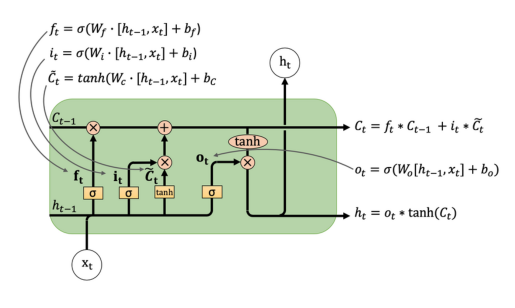

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

referenceImage = mpimg.imread('image.png')

plt.imshow(referenceImage)
plt.axis('off') 
plt.show()


In [41]:
#lr -> forget
#p ->c
#pr i
#c >
import numpy as np

class LSTM :

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def tanh(self, x):
        return np.tanh(x)

    def __init__(self, weights = [0, 0, 0, 0,0,0,0,0], biases = [0, 0, 0, 0]):
        self.Wf1,self.Wf2,self.Bf1 = weights[0], weights[1], biases[0]
        self.Wi1,self.Wi2,self.Bi1 = weights[2], weights[3], biases[1]
        self.Wc1,self.Wc2,self.Bc1 = weights[4], weights[5], biases[2]
        self.Wo1,self.Wo2,self.Bo1 = weights[6], weights[7], biases[3]
        self.h = 0
        self.c = 0
    def forward(self, x):
        f = self.sigmoid(self.h*self.Wf1+ x*self.Wf2 +self.Bi1) #long term memory percent to remember
        k1 = self.sigmoid(self.h*self.Wi1 + x*self.Wi2)    #Percent of potential memory to remember
        k2 = self.tanh(self.h*self.Wc1 + x*self.Wc2 + self.Bc1) #Potential long term memory
        self.c = k1*k2 + f*self.c #New long term memory
        o = self.sigmoid(self.h*self.Wo1 + x*self.Wo2 + self.Bo1) #% potential memory to output
        self.h = o * self.tanh(self.c) #New short term memory
        
        return (self.c,self.h)
    def predict(self,x) :
        #x is list of data points
        #returns h,c
        for dataPoint in x :
            self.forward(dataPoint)
        return (self.c, self.h)
    def trainOne(self, x, y, learningRate=0.01):

        # x is single list of data points
        # y is a single data point that is the expected output
        previousC = []
        previousH = []
        previousF = []
        previousK1 = []
        previousK2 = []
        previousO = []

        self.h = 0
        self.c = 0

        for dataPoint in x:
            f_in = self.h*self.Wf1 + dataPoint*self.Wf2 + self.Bf1
            k1_in = self.h*self.Wi1 + dataPoint*self.Wi2 + self.Bi1
            k2_in = self.h*self.Wc1 + dataPoint*self.Wc2 + self.Bc1
            o_in = self.h*self.Wo1 + dataPoint*self.Wo2 + self.Bo1

            f = self.sigmoid(f_in)
            k1 = self.sigmoid(k1_in)
            k2 = self.tanh(k2_in)
            o = self.sigmoid(o_in)

            previousF.append((f, f_in))
            previousK1.append((k1, k1_in))
            previousK2.append((k2, k2_in))
            previousO.append((o, o_in))

            a, b = self.forward(dataPoint)
            previousC.append(a)
            previousH.append(b)

        # Mean squared error loss
        error = previousH[-1] - y
        dLoss_dh = error  # ∂L/∂h
        dLoss_dc = dLoss_dh * previousO[-1][0] * (1 - np.tanh(previousC[-1])**2)

        dWo1 = dWo2 = dBo1 = 0
        dWc1 = dWc2 = dBc1 = 0
        dWi1 = dWi2 = dBi1 = 0
        dWf1 = dWf2 = dBf1 = 0

        dh_next = 0
        dc_next = 0

        for t in reversed(range(len(x))):
            f, f_in = previousF[t]
            k1, k1_in = previousK1[t]
            k2, k2_in = previousK2[t]
            o, o_in = previousO[t]
            c = previousC[t]
            h = previousH[t]
            inp = x[t]
            h_prev = previousH[t-1] if t > 0 else 0
            c_prev = previousC[t-1] if t > 0 else 0

            # Gradients of output gate
            do = dLoss_dh * np.tanh(c)
            do_in = do * o * (1 - o)
            dWo1 += do_in * h_prev
            dWo2 += do_in * inp
            dBo1 += do_in

            # Gradients w.r.t. cell state
            dc = dLoss_dh * o * (1 - np.tanh(c)**2) + dc_next
            dk1 = dc * k2
            dk2 = dc * k1
            df = dc * c_prev

            # Input gate
            dk1_in = dk1 * k1 * (1 - k1)
            dWi1 += dk1_in * h_prev
            dWi2 += dk1_in * inp
            dBi1 += dk1_in

            # Candidate memory
            dk2_in = dk2 * (1 - k2**2)
            dWc1 += dk2_in * h_prev
            dWc2 += dk2_in * inp
            dBc1 += dk2_in

            # Forget gate
            df_in = df * f * (1 - f)
            dWf1 += df_in * h_prev
            dWf2 += df_in * inp
            dBf1 += df_in

            # Update for next step
            dh_next = (do_in * self.Wo1 +
                       dk1_in * self.Wi1 +
                       dk2_in * self.Wc1 +
                       df_in * self.Wf1)
            dc_next = dc * f

        # Apply gradient descent
        self.Wo1 -= learningRate * dWo1
        self.Wo2 -= learningRate * dWo2
        self.Bo1 -= learningRate * dBo1

        self.Wi1 -= learningRate * dWi1
        self.Wi2 -= learningRate * dWi2
        self.Bi1 -= learningRate * dBi1

        self.Wc1 -= learningRate * dWc1
        self.Wc2 -= learningRate * dWc2
        self.Bc1 -= learningRate * dBc1

        self.Wf1 -= learningRate * dWf1
        self.Wf2 -= learningRate * dWf2
        self.Bf1 -= learningRate * dBf1

        return error

In [42]:
import numpy as np
import matplotlib.pyplot as plt

timesteps = 150
x = np.arange(timesteps)
y = np.sin(x * (2 * np.pi / timesteps))

lstm = LSTM(weights=[0,0,0,0,0,0,0,0], biases=[0,0,0,0])
sequence_length = 5
data = []
labels = []

for i in range(len(y) - sequence_length):
    data.append(list(y[i:i + sequence_length]))
    labels.append(y[i + sequence_length])

In [ ]:
sequence_length = 5
data = []
labels = []
for i in range(len(y) - sequence_length):
    data.append(list(y[i:i + sequence_length]))
    labels.append(y[i + sequence_length])
lstm = LSTM()
for epoch in range(600):
    total_error = 0
    for i in range(len(data)):
        error = lstm.trainOne(data[i], labels[i], learningRate=0.01)
        total_error += error**2
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Error: {total_error}")


Epoch 0, Total Error: 45.74593499522414
Epoch 100, Total Error: 1.0650361643279205
Epoch 100, Total Error: 1.0650361643279205
Epoch 200, Total Error: 0.5724796807223859
Epoch 200, Total Error: 0.5724796807223859
Epoch 300, Total Error: 0.40291095419736017
Epoch 300, Total Error: 0.40291095419736017
Epoch 400, Total Error: 0.32043103393038286
Epoch 400, Total Error: 0.32043103393038286
Epoch 500, Total Error: 0.278466264277122
Epoch 500, Total Error: 0.278466264277122


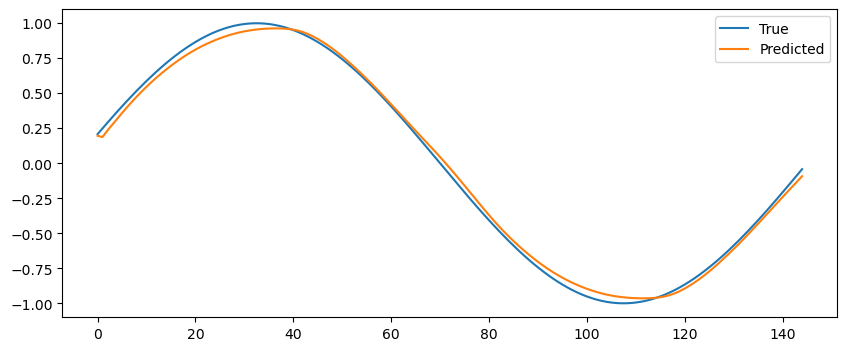

In [46]:
import matplotlib.pyplot as plt

predictions = []
for seq in data:
    _, pred = lstm.predict(seq)
    predictions.append(pred)

plt.figure(figsize=(10,4))
plt.plot(range(len(labels)), labels, label='True')
plt.plot(range(len(predictions)), predictions, label='Predicted')
plt.legend()
plt.show()

In [47]:
def predict_custom_sequence(input_sequence):
    _, pred = lstm.predict(input_sequence)
    return pred

custom_input = [0, np.pi/10, np.pi/5, np.pi/3, np.pi/2]  
predicted_output = predict_custom_sequence(custom_input)
print(f"Predicted output for custom input (radians): {predicted_output}")


Predicted output for custom input (radians): 0.9174514952122966
